In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
from scipy.fftpack import dct, idct
from scipy.optimize import minimize
sns.set_theme()

In [21]:
def cosamp(phi, u, s, epsilon=1e-10, max_iter=1000):
    """
    Return an `s`-sparse approximation of the target signal
    Input:
        - phi, sampling matrix
        - u, noisy sample vector
        - s, sparsity
    """
    a = np.zeros(phi.shape[1])
    v = u
    it = 0 # count
    halt = False
    while not halt:
        it += 1
        print("Iteration {}\r".format(it), end="")
        
        y = np.dot(np.transpose(phi), v)
        omega = np.argsort(y)[-(2*s):] # large components
        omega = np.union1d(omega, a.nonzero()[0]) # use set instead?
        phiT = phi[:, omega]
        b = np.zeros(phi.shape[1])
        # Solve Least Square
        b[omega], _, _, _ = np.linalg.lstsq(phiT, u)
        
        # Get new estimate
        b[np.argsort(b)[:-s]] = 0
        a = b
        
        # Halt criterion
        v_old = v
        v = u - np.dot(phi, a)

        halt = (np.linalg.norm(v - v_old) < epsilon) or \
            np.linalg.norm(v) < epsilon or \
            it > max_iter
        
    return a

In [26]:
np.random.seed(0)
n = 4096
t = np.linspace(0, 1, n)
signal = np.cos(2 * 97 * np.pi * t) + np.cos(2 * 777 * np.pi * t)
noise = np.random.normal(0, 0.5, len(t))
x = signal + noise
xt = np.fft.fft(x)
PSD = xt * np.conj(xt) / n #Power spectral denstiy, ||xt||^2 / n

In [27]:
# Randomly sampled signal
num_samples = 128 
permutation = np.floor(np.random.rand(num_samples) * n).astype(int)
compressed_signal = x[permutation]

In [28]:
# Solve compressed sensing problem
Psi = dct(np.identity(n))
Theta = Psi[permutation, :]

s = cosamp(Theta, compressed_signal, 10, epsilon = 1.e-10, max_iter = 10)
x_reconstructed = idct(s)
xt_reconstructed = np.fft.fft(x_reconstructed, n)
PSD_reconstructed = xt_reconstructed * np.conj(xt_reconstructed) / n

/Users/Jonas/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


/Users/Jonas/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


Text(0, 0.5, '')

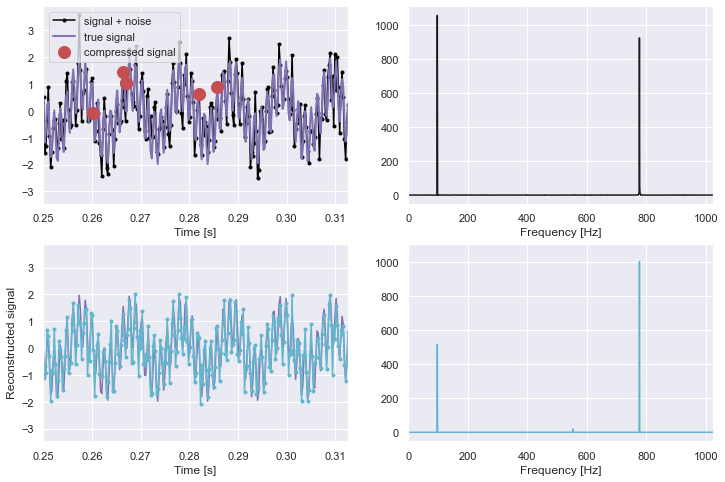

In [51]:
time_window = np.array([1024, 1280])/n
freq = np.arange(n)
L = int(np.floor(n/2))

fig, ax = plt.subplots(2,2, figsize = (12, 8))
ax = ax.reshape(-1)

ax[0].plot(t, x, '.-', color = 'black', label = 'signal + noise')
ax[0].plot(t, signal, 'm', linewidth = 2, label = 'true signal')
ax[0].plot(permutation/n, compressed_signal, marker = 'o', color = 'r', ms = 12, linewidth = 0, label = 'compressed signal')
ax[0].set_xlim(time_window[0], time_window[1]) 
ax[0].set_xlabel('Time [s]')
ax[0].legend()

ax[1].plot(freq[:L], PSD[:L].real, color = 'k')
ax[1].set_xlim(0, 1024)
ax[1].set_xlabel('Frequency [Hz]')

ax[2].plot(t, signal, 'm', label = 'true signal')
ax[2].plot(t, x_reconstructed, '.-', color = 'c')
ax[2].set_xlim(time_window[0], time_window[1])
ax[2].set_ylim(ax[0].get_ylim())
ax[2].set_xlabel(ax[0].get_xlabel())
ax[2].set_ylabel('Reconstructed signal')

ax[3].plot(freq[:L], PSD_reconstructed[:L], color = 'c')
ax[3].set_xlim(ax[1].get_xlim())
ax[3].set_ylim(ax[1].get_ylim())
ax[3].set_xlabel(ax[1].get_xlabel())
ax[3].set_ylabel(ax[1].get_ylabel())